# 🧩 Customer Segmentation (Clustering)
### Using All Demographic, Behavioral, Policy, Financial, and Risk Features

This notebook performs unsupervised clustering to identify meaningful customer segments.
We use:
- K-Means
- DBSCAN
- PCA for visualization

All features from the processed dataset are included.

## 📦 Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

sns.set(style="whitegrid")
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

## 📁 Load Preprocessed Dataset

In [2]:
df = pd.read_csv("../data/processed_customer_dataset.csv")
df.head()

,Customer ID,Age,Income Level,Location,Claim History,Coverage Amount,Premium Amount,Deductible,Risk Profile,Previous Claims History,...,Driving Record_Major Violations,Driving Record_Minor Violations,Life Events_Divorce,Life Events_Job Change,Life Events_Marriage,Life Events_Retirement,Segmentation Group_Segment2,Segmentation Group_Segment3,Segmentation Group_Segment4,Segmentation Group_Segment5
0,1.161055,-1.401980,-0.333617,-0.636458,1.416283,-0.469361,-0.213640,0.871878,-0.525889,1.212606,...,False,False,False,True,False,False,False,False,False,True
1,1.537483,-1.203033,-0.780348,0.377921,-1.441872,1.071729,-0.822588,0.587999,-0.525889,0.301218,...,False,False,False,False,False,True,False,False,False,True
2,-1.481328,-1.004085,-0.241996,-0.020824,0.844652,1.048219,1.080474,0.886162,0.354840,-0.610170,...,False,False,False,False,False,False,False,True,False,False
3,0.879390,-1.600928,-0.528975,-1.216311,1.416283,1.099966,1.025256,1.252169,1.235569,-1.521558,...,False,False,False,True,False,False,False,True,False,False
4,1.274459,-1.269349,-1.199821,1.541248,0.273021,-0.469722,-1.359210,-1.754449,-1.406619,1.212606,...,True,False,False,False,False,False,True,False,False,False


## 🔧 Prepare Feature Matrix for Clustering
Using all features.

In [3]:
X = df.copy().drop(columns=["Customer ID"])  # all features included
X.shape

(53503, 107)

## Apply PCA Reduction
We standardize all features so that clustering algorithms (like KMeans and DBSCAN) 
treat each feature equally. Without scaling, features with larger ranges dominate distance calculations.

In [4]:
# Fit PCA and compute cumulative variance
pca = PCA().fit(X)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1

# Reduce dataset
pca = PCA(n_components=n_components_90)
X_pca = pca.fit_transform(X)

print("Reduced shape:", X_pca.shape)

Reduced shape: (53503, 52)


## 🎯 K-Means Clustering
We will:
- Use Elbow Method to find optimal K
- Fit K-Means
- Evaluate using Silhouette Score

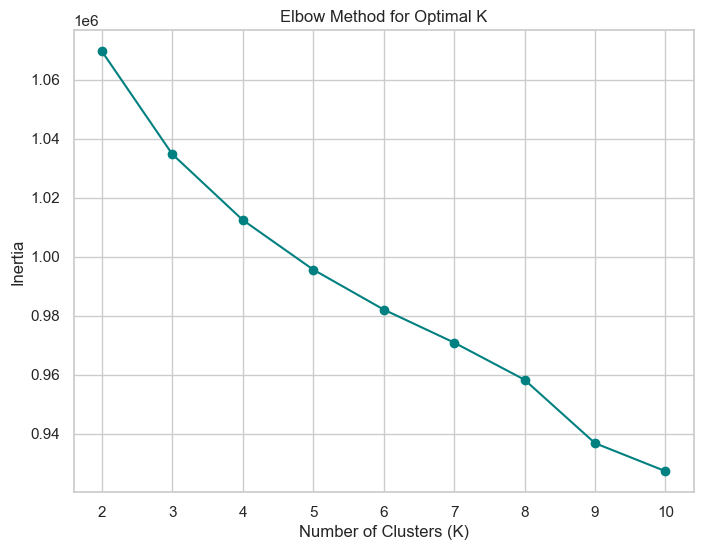

In [5]:
inertia = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,6))
plt.plot(K_range, inertia, marker='o', color='teal')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.grid(True)
plt.show()

In [6]:
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
X["KMeans_Cluster"] = kmeans.fit_predict(X_pca)

sil_score = silhouette_score(X, X["KMeans_Cluster"])
sil_score

0.05301010669336679

## 🎨 PCA Visualization (2D)

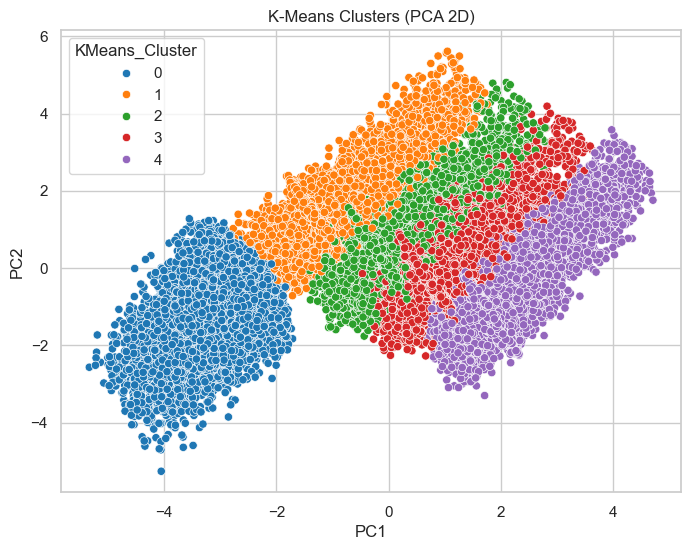

In [7]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X)

X["PC1"] = pca_components[:, 0]
X["PC2"] = pca_components[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(
    x="PC1", y="PC2",
    hue=X["KMeans_Cluster"],
    palette="tab10",
    data=X
)
plt.title("K-Means Clusters (PCA 2D)")
plt.show()

## 🌀 DBSCAN Clustering
Useful for detecting outliers and irregular cluster shapes.

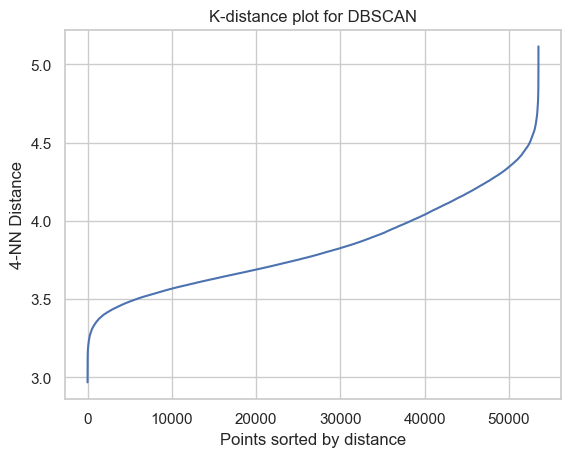

In [8]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_pca)
distances, indices = neighbors_fit.kneighbors(X_pca)

distances = np.sort(distances[:,4])  # 4th nearest neighbor
plt.plot(distances)
plt.ylabel("4-NN Distance")
plt.xlabel("Points sorted by distance")
plt.title("K-distance plot for DBSCAN")
plt.show()

In [9]:
dbscan = DBSCAN(eps=5.0, min_samples=20)
X["DBSCAN_Cluster"] = dbscan.fit_predict(X_pca)

print("DBSCAN Cluster Counts:", X["DBSCAN_Cluster"].value_counts())

DBSCAN Cluster Counts: DBSCAN_Cluster
0    53503
Name: count, dtype: int64


### DBSCAN Clustering Insights

- **Result**: DBSCAN assigned all 53,503 points to a single cluster (`0`).
- **Interpretation**:
  - No noise points (`-1`) were detected.
  - The algorithm considered the entire dataset as one dense region.
  - This outcome suggests that the chosen parameters (`eps`, `min_samples`) did not reveal meaningful subclusters.
- **Why this happened**:
  - `eps` may have been too large, merging all points into one cluster.
  - High dimensionality (even after PCA) can compress distances, making density differences harder to detect.
  - The dataset may lack strong density variations for DBSCAN to separate.

## Visualize DBSCAN Clusters in PCA 2D
We reduce the dataset to 2 PCA components for visualization and plot DBSCAN clusters.
Noise points are labeled as -1.

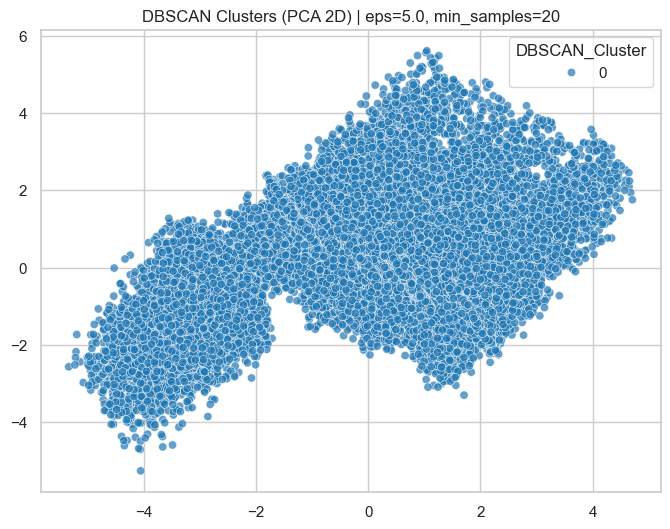

In [10]:
eps, min_samples = 5.0, 20
db = DBSCAN(eps=eps, min_samples=min_samples).fit(X_pca)
X["DBSCAN_Cluster"] = db.labels_

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=pca_components[:,0], y=pca_components[:,1],
    hue=X["DBSCAN_Cluster"],
    palette="tab10",
    alpha=0.7
)
plt.title(f"DBSCAN Clusters (PCA 2D) | eps={eps}, min_samples={min_samples}")
plt.show()

## 🌿 Dendrogram

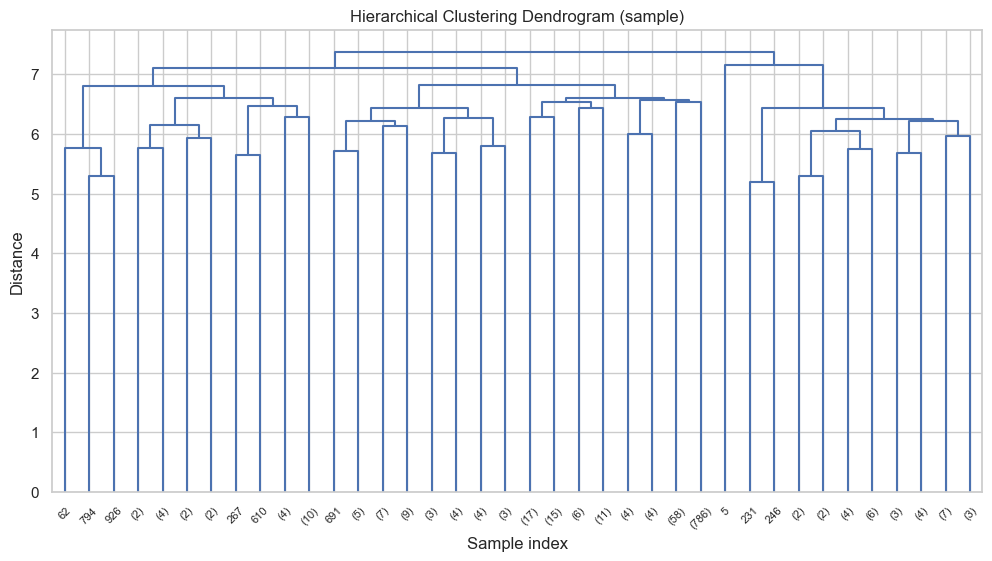

In [17]:
# Use a smaller sample for clarity
sample_idx = np.random.choice(len(X_pca), size=1000, replace=False)
X_sample = X_pca[sample_idx]

# Perform hierarchical clustering (linkage matrix)
Z = linkage(X_sample, method='average')

# Plot dendrogram
plt.figure(figsize=(12,6))
dendrogram(Z, truncate_mode="level", p=5)
plt.title("Hierarchical Clustering Dendrogram (sample)")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.show()

## 💾 Save Segmented Dataset

In [20]:
X.to_csv("../data/segmented_customers.csv", index=False)
print("Segmented dataset saved successfully!")

Segmented dataset saved successfully!


## 🧠 Cluster Profiling
Analyze average values per cluster to understand customer groups.

In [23]:
# KMeans Cluster Profiling
kmeans_profile = X.groupby("KMeans_Cluster").mean()
kmeans_counts = X["KMeans_Cluster"].value_counts().sort_index()
kmeans_profile["Count"] = kmeans_counts.values

# DBSCAN Cluster Profiling
dbscan_profile = X.groupby("DBSCAN_Cluster").mean()
dbscan_counts = X["DBSCAN_Cluster"].value_counts().sort_index()
dbscan_profile["Count"] = dbscan_counts.values

print("=== KMeans Cluster Profiling ===")
display(kmeans_profile)

print("\n=== DBSCAN Cluster Profiling ===")
display(dbscan_profile)

=== KMeans Cluster Profiling ===


,Age,Income Level,Location,Claim History,Coverage Amount,Premium Amount,Deductible,Risk Profile,Previous Claims History,Credit Score,...,Life Events_Marriage,Life Events_Retirement,Segmentation Group_Segment2,Segmentation Group_Segment3,Segmentation Group_Segment4,Segmentation Group_Segment5,PC1,PC2,DBSCAN_Cluster,Count
KMeans_Cluster,,,,,,,,,,,,,,,,,,,,,
0,-0.052955,0.004404,-0.027170,-0.004680,-0.016346,0.005877,0.004832,0.029152,0.002019,-0.003755,...,0.257098,0.168036,0.203055,0.178556,0.198876,0.254792,-3.025326,-1.061951,0.0,6939
1,0.084267,-0.151012,0.128374,-0.050043,1.063544,0.074984,-0.010019,0.041497,0.739556,0.013986,...,0.252256,0.186101,0.210018,0.175181,0.183845,0.274639,-1.067272,1.265619,0.0,11080
2,1.045868,0.042041,-0.000234,0.043477,-0.138105,-0.076605,0.010876,-0.156889,-0.768363,-0.018072,...,0.230253,0.173302,0.213385,0.180103,0.186270,0.264442,-0.040399,0.437121,0.0,11027
3,-0.124855,0.065753,-0.102652,-0.031439,-0.814911,0.024230,0.060822,-0.000988,0.957272,0.034436,...,0.261860,0.163589,0.230346,0.161894,0.185954,0.262199,0.795468,-0.092944,0.0,11804
4,-0.839739,0.031844,-0.001547,0.037827,-0.041772,-0.024729,-0.060095,0.085324,-0.872141,-0.026564,...,0.257172,0.164230,0.208172,0.173872,0.194341,0.249269,1.886817,-0.820138,0.0,12653



=== DBSCAN Cluster Profiling ===


,Age,Income Level,Location,Claim History,Coverage Amount,Premium Amount,Deductible,Risk Profile,Previous Claims History,Credit Score,...,Life Events_Marriage,Life Events_Retirement,Segmentation Group_Segment2,Segmentation Group_Segment3,Segmentation Group_Segment4,Segmentation Group_Segment5,KMeans_Cluster,PC1,PC2,Count
DBSCAN_Cluster,,,,,,,,,,,,,,,,,,,,,
0,-9.900559e-17,-7.585614e-17,-4.103652e-17,-4.872672e-17,2.733901e-17,8.515659e-17,4.341040e-18,-5.362803e-17,-3.949371e-17,5.709463e-16,...,0.251631,0.170981,0.213857,0.173392,0.189242,0.261219,2.227127,9.523727e-17,-2.203306e-17,53503


### Cluster Profiling (KMeans vs DBSCAN)

- **KMeans Profiling**: Shows mean feature values and record counts per cluster, highlighting differences in customer segments (e.g., average premium, claim frequency, fraud rate).
- **DBSCAN Profiling**: Shows mean feature values and record counts per density-based cluster. If DBSCAN produces only one cluster, profiling reflects overall dataset averages.
- **Business Insight**: Profiling connects technical clustering output to real-world interpretation, enabling us to describe customer segments in terms of premiums, claims, and fraud likelihood.

## ✅ Next Steps

- Build customer personas from cluster profiles  
- Integrate segmentation into Streamlit dashboard  
- Use clusters to enhance fraud detection  
- Add t-SNE visualization for deeper insights  